In [1]:
import json
from flatten_json import flatten
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors


In [2]:
with open('data/shots_goals_data.json', 'r') as f:
    data = json.load(f)
record_flattened = [flatten(record) for record in data]
shot_goals_dataframe = pd.DataFrame(record_flattened)
shot_goals_dataframe.to_csv('shots_goals_data.csv')
display(shot_goals_dataframe.head())  


shot_goals_dataframe['shooting_team'].nunique()

,coor_x,coor_y,event_type,coor_x_normalized,coor_y_normalized,game_id,shooting_team,shooting_team_home_or_away,shot_goal_defending_team
0,85.0,-1.0,Goal,85.0,-1.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
1,-32.0,-2.0,Shot,32.0,2.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
2,63.0,-6.0,Shot,63.0,-6.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
3,-59.0,-20.0,Shot,59.0,20.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
4,-42.0,-29.0,Shot,42.0,29.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators


32

## Goal Conversion Ratio

In [3]:
team_a = "Toronto Maple Leafs" #input("Enter Your Team Name: ")
team_b = "Ottawa Senators" #input("Enter Opposition Team Name: ")

# find all the records where these teams have played
condition = ((shot_goals_dataframe['shooting_team'] == team_a) & 
             (shot_goals_dataframe['shot_goal_defending_team'] == team_b)) | ((shot_goals_dataframe['shooting_team'] == team_b) & 
            (shot_goals_dataframe['shot_goal_defending_team'] == team_a))
filtered_dataframe = shot_goals_dataframe[condition]
display(filtered_dataframe)

,coor_x,coor_y,event_type,coor_x_normalized,coor_y_normalized,game_id,shooting_team,shooting_team_home_or_away,shot_goal_defending_team
0,85.0,-1.0,Goal,85.0,-1.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
1,-32.0,-2.0,Shot,32.0,2.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
2,63.0,-6.0,Shot,63.0,-6.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
3,-59.0,-20.0,Shot,59.0,20.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
4,-42.0,-29.0,Shot,42.0,29.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
...,...,...,...,...,...,...,...,...,...
165666,-80.0,23.0,Shot,80.0,-23.0,2021020567,Toronto Maple Leafs,Home,Ottawa Senators
165667,72.0,-18.0,Shot,72.0,-18.0,2021020567,Ottawa Senators,Away,Toronto Maple Leafs
165668,68.0,14.0,Shot,68.0,14.0,2021020567,Ottawa Senators,Away,Toronto Maple Leafs
165669,-57.0,2.0,Goal,57.0,-2.0,2021020567,Toronto Maple Leafs,Home,Ottawa Senators


## GOAL CONVERSION RATIO OF TEAM A TO TEAM B

In [4]:
team_a_shots_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Shot'))
team_a_goals_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Goal'))
shots_from_filtered_dataframe = filtered_dataframe[team_a_shots_condition]
goals_from_filtered_dataframe = filtered_dataframe[team_a_goals_condition]

total_attempts = shots_from_filtered_dataframe.shape[0] + goals_from_filtered_dataframe.shape[0]
total_goals = goals_from_filtered_dataframe.shape[0]
goal_conversion_ratio = (total_goals / total_attempts) * 100 

print('The goal conversion ratio of \'{}\' against \'{}\' is {}%'.format(team_a, team_b, round(goal_conversion_ratio,2)))


The goal conversion ratio of 'Toronto Maple Leafs' against 'Ottawa Senators' is 10.51%


## Plot the shot attempts on the NHL rink 

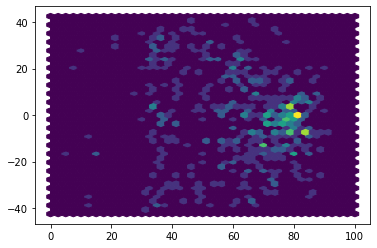

'Now working on Goals'

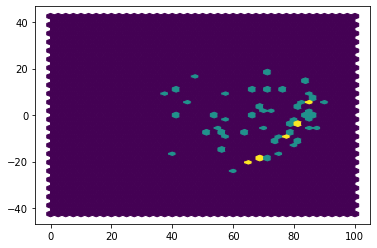

In [5]:
rink_size = [0, 100.0, -42.5, 42.5]
#plotting shots
shots_x_coordinates = shots_from_filtered_dataframe['coor_x_normalized'].to_numpy()
shots_y_coordinates = shots_from_filtered_dataframe['coor_y_normalized'].to_numpy()

#creating a hexbin plot to find the density of the attempted shots
shots_hexbin_plot =  plt.hexbin(shots_x_coordinates, shots_y_coordinates, gridsize=40, extent=rink_size)
#finding the centres of each hexbin 
shots_hexbin_offsets = shots_hexbin_plot.get_offsets();
#finding the values of the hexagons
shots_hexbin_values = shots_hexbin_plot.get_array();
plt.show()
display("Now working on Goals")
#plotting goals
goals_x_coordinates = goals_from_filtered_dataframe['coor_x_normalized'].to_numpy()
goals_y_coordinates = goals_from_filtered_dataframe['coor_y_normalized'].to_numpy()
goals_hexbin_plot =  plt.hexbin(goals_x_coordinates, goals_y_coordinates, gridsize=40, extent=rink_size)
goals_hexbin_offsets = goals_hexbin_plot.get_offsets()
goals_hexbin_values = goals_hexbin_plot.get_array();
plt.show()

/var/folders/f7/3hptwq1j75nc45cd5svs7y0h0000gn/T/ipykernel_48577/3797214817.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  shot_hexagon = RegularPolygon((vertex[0],vertex[1]), numVertices=3, radius=hex_radius,
/var/folders/f7/3hptwq1j75nc45cd5svs7y0h0000gn/T/ipykernel_48577/3797214817.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  goal_hexagon = RegularPolygon((vertex[0], vertex[1]), numVertices = 6, radius = hex_radius,


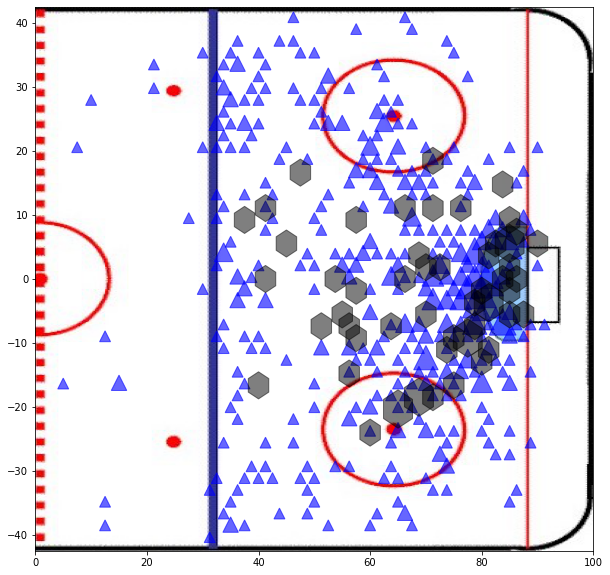

In [6]:
figure = plt.figure(figsize = (10,10))
figure_subplot = figure.add_subplot(111)
figure_subplot.set_ylim(ymin = -42.5, ymax = 42.5)
figure_subplot.set_xlim(xmin = 0.0, xmax = 100)

rink_image = Image.open('assets/NHL-Rink-Half.jpeg') 
printed = plt.imshow(rink_image, extent = [0, 100, -42.5, 42.5 ], aspect = 'auto')

for counter, vertex in enumerate(shots_hexbin_offsets):
    if shots_hexbin_values[counter] < 1:
        continue       
    shots_hexbin_value_scaled = shots_hexbin_values[counter] / max(shots_hexbin_values)
    hex_radius = 3 * math.sqrt(shots_hexbin_value_scaled)
    shot_hexagon = RegularPolygon((vertex[0],vertex[1]), numVertices=3, radius=hex_radius, 
                    orientation=np.radians(0), alpha=0.6, edgecolor='Blue', color = 'Blue')
    figure_subplot.add_patch(shot_hexagon)
    
for counter, vertex in enumerate(goals_hexbin_offsets):
    if goals_hexbin_values[counter] < 1:
        continue
    goals_hexbin_value_scaled = goals_hexbin_values[counter] / max(goals_hexbin_values)
    hex_radius = 3 * math.sqrt(goals_hexbin_value_scaled)
    goal_hexagon = RegularPolygon((vertex[0], vertex[1]), numVertices = 6, radius = hex_radius, 
                    orientation = np.radians(0), alpha = 0.5, edgecolor = 'Black', color = 'Black')
    figure_subplot.add_patch(goal_hexagon)    

In [19]:
shots_df = pd.DataFrame({'Shots X coordinates': shots_x_coordinates, 
                         'Shots Y coordinates': shots_y_coordinates})
goals_df = pd.DataFrame({'Goals X coordinates': goals_x_coordinates, 
                         'Goals Y coordinates': goals_y_coordinates})
combined_df = pd.concat([shots_df, goals_df], axis = 1)
display(combined_df)

combined_df.to_csv("data/visualization/shots_to_goals_coordinates.csv")

,Shots X coordinates,Shots Y coordinates,Goals X coordinates,Goals Y coordinates
0,32.0,2.0,86.0,0.0
1,59.0,20.0,84.0,2.0
2,42.0,29.0,83.0,5.0
3,52.0,7.0,65.0,-20.0
4,38.0,-38.0,78.0,-9.0
...,...,...,...,...
472,32.0,20.0,NaN,NaN
473,47.0,-32.0,NaN,NaN
474,88.0,7.0,NaN,NaN
475,80.0,-23.0,NaN,NaN
